# <font size="7"> **Assignment-7**</font>
I hope this assignment will give you clarity on how mathematical models like **Multilayer Perceptrons (MLP)** can be made from scratch using **PyTorch** & can be used to solve complex, non-linear geometric problems **without relying on black-box libraries**.

---
# ⚫ **Mission Critical: The Exclusion Zone Protocol**

**Date:** Year 2142  
**Location:** Exoplanet *Kepler-186f*   **Clearance:** IITians

---

### **⚫ The Story**
Humanity has colonized the distant exoplanet *Kepler-186f*. While the surface is habitable, the planet's magnetic core is unstable. The **Global Defense Council (GDC)** has identified a dangerous phenomenon known as the **"Radiation Ring."**

Sensors indicate that the safe zones on the planet follow a peculiar geometry:
* ⚫ **The Core Zone:** Distance $< 2$ km from the colony center (Safe).
* ⚫ **The Outer Wilds:** Distance $> 4$ km from the colony center (Safe).
* ⚫ **The Dead Zone:** The region **between 2 km and 4 km** is flooded with lethal gamma radiation.

Your engineering team has deployed **3,000 sensor drones** across the colony to map this danger. Each drone reports its coordinates $(x, y)$ and a binary label:
* `1`: Radiation Detected (Dead Zone)
* `0`: Safe Zone

 **⚫ The Problem:** The sensors are cheap and prone to interference. Approximately **5%** of the drones are malfunctioning and reporting the wrong safety status (noise). The GDC mainframe is a legacy system that forbids the use of modern "Neural Libraries" (i.e., you cannot use `torch.nn` or `torch.optim`). You must build a **Multi-Layer Perceptron (MLP) from scratch** to filter out the noise and mathematically define the Exclusion Zone boundaries using **PyTorch**. ( Hint: You know this is a binary classification problem, which Loss function would you use?? )

---

### **⚫ Your Objective**

1.  **Initialize the System:** Use your **Group Number** as the random seed. This ensures your team works on a unique sensor distribution pattern.
2.  **Architect the Filter:** Construct a neural network with **3 hidden layers** (16 neurons each) to learn the non-linear "donut" shape of the Dead Zone.
3.  **Manual Calibration:** You cannot use auto-optimizers. You must manually calculate the gradients (Backpropagation) and update the system weights using **Gradient Descent**.
4.  **Verify Integrity:** Split your sensor data (70% training, 30% validation). Prove that your system doesn't just memorize the malfunctioning sensors (overfitting) but actually learns the geometric shape of the Dead Zone.

---

## ⚫ Engineering Constraints (Read Carefully)

**1. Restricted Modules**
*  **Forbidden:** You are strictly forbidden from importing `torch.nn` (Layers/Loss) or `torch.optim` (Optimizers).
*  **Allowed:** `import torch`, `import matplotlib.pyplot`, `import pandas`, `import numpy`, using `sklearn`.


**2. The Mechanics**
* **Forward Pass:** Must be implemented using raw matrix multiplication (`torch.matmul`) and bias addition.
* **Backward Pass:** You **MAY** use `loss.backward()` to compute gradients automatically (Autograd).
* **Optimization:** You **MUST** implement the weight updates manually (Stochastic Gradient Descent).
    > `w_new = w_old - learning_rate * w_old.grad`

**3. Loss Function**
Since `torch.nn` is banned, you must implement **Binary Cross Entropy** manually using basic tensor math.

$$Loss = -\frac{1}{N} \sum_{i=1}^{N} [y_i \cdot \log(\hat{y}_i) + (1-y_i) \cdot \log(1-\hat{y}_i)]$$

* **Note:** Ensure you handle the log of zero (numerical stability) or use `torch.clamp` to avoid `NaN` errors.

**4. Visual Proof:** Your final output must include a Decision Boundary Map showing the "Donut" shape.


---

### ⚫ **The GDC Dashboard (Required Output)**



The Global Defense Council requires visual confirmation that your system is stable before we can upload it to the drone fleet. You must generate a **3-Panel Heads-Up Display (HUD)** containing the following telemetry:

**1. System Error Trajectory (Loss Plot)**
* **Mission:** Plot the **Training Loss** (Blue) vs. **Validation Loss** (Orange) over all epochs.
* **Why:** We need to confirm that the system is actually learning and not just diverging (exploding gradients).

**2. Integrity Check (Accuracy Plot)**
* **Mission:** Plot the **Training Accuracy** vs. **Validation Accuracy**.
* **Why:** If Training Accuracy is high (95%) but Validation Accuracy is low (80%), you have failed to generalize. This is a sign of **Overfitting**—memorizing sensor noise instead of the Radiation Ring.

**3. Geospatial Threat Map (Decision Boundary)**
* **Mission:** Visualize the **Validation Set** on a 2D map.
* **Overlay:** Draw the neural network's **Decision Boundary** (the contours where confidence = 0.5).
* **Why:** The Commander needs to *see* the "Donut" shape. If your boundary looks like a jagged mess, the model is rejected.

---

In [8]:
import torch
import numpy as np
# ===========================================================
# PART 1: Data Generation (The Exclusion Zone)
# ===========================================================

# ⚠️ INSTRUCTION: Replace 1 with your actual Group Number
GROUP_NUMBER = 7

# Set seed for reproducibility
torch.manual_seed(GROUP_NUMBER)
np.random.seed(GROUP_NUMBER)

def generate_data(n_samples=3000):
    """
    Generates 3000 sensor readings for the Kepler-186f Exclusion Zone.
    Shape: Concentric circles (Donut).
    Logic:
      - Dead Zone (1): 2km < distance < 4km
      - Safe Zone (0): distance < 2km OR distance > 4km
    """
    # Generate random coordinates between -5 and 5 km
    X = (torch.rand(n_samples, 2) * 10) - 5

    # Calculate distance from center (radius)
    radius = torch.sqrt(X[:, 0]**2 + X[:, 1]**2)

    # Assign Labels: 1 if inside the Dead Zone, 0 otherwise
    y = ((radius > 2) & (radius < 4)).float().view(-1, 1)

    # Add 5% Noise (Malfunctioning Drones)
    n_noise = int(0.05 * n_samples)
    noise_indices = torch.randperm(n_samples)[:n_noise]
    y[noise_indices] = 1 - y[noise_indices] # Flip labels

    return X, y

# Generate the dataset
X_full, y_full = generate_data(3000)

print(f"Data Generated: {X_full.shape} samples.")
print(f"Target Generated: {y_full.shape} labels.")

Data Generated: torch.Size([3000, 2]) samples.
Target Generated: torch.Size([3000, 1]) labels.


In [ ]:
# ==============================================================================
# Code from here. Best of luckk :)
# ==============================================================================

In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
GROUP_SEED = 7 
torch.manual_seed(GROUP_SEED)
np.random.seed(GROUP_SEED)

def generate_kepler_data(n_points=3000):
    """
    Creates the 'Donut' geometry:
    - Dead Zone (1): 2km < r < 4km
    - Safe Zone (0): r < 2km or r > 4km
    """
    
    coords = (torch.rand(n_points, 2) * 10) - 5
    
  
    radii = torch.sqrt(coords[:, 0]**2 + coords[:, 1]**2)
    
     
    labels = ((radii > 2) & (radii < 4)).float().view(-1, 1)
    
     
    noise_mask = torch.rand(n_points) < 0.05
    labels[noise_mask] = 1 - labels[noise_mask]  
    
    return coords, labels

X_full, Y_full = generate_kepler_data(3000)

In [11]:
shuffled_indices = torch.randperm(X_full.size(0))
split_limit = int(0.7 * X_full.size(0))

train_idx, val_idx = shuffled_indices[:split_limit], shuffled_indices[split_limit:]

X_train, Y_train = X_full[train_idx], Y_full[train_idx]
X_val, Y_val     = X_full[val_idx], Y_full[val_idx]

print(f"Data ready. Training: {X_train.shape}, Validation: {X_val.shape}")

Data ready. Training: torch.Size([2100, 2]), Validation: torch.Size([900, 2])


In [ ]:
def init_params(in_dim, out_dim, last_layer=False):
    """
    Initializes weights using Variance Scaling (He/Xavier logic).
    Ensures gradients don't explode or vanish during training.
    """
    
    scale = torch.sqrt(torch.tensor((2.0 if not last_layer else 1.0) / in_dim))
    
    W = (torch.randn(in_dim, out_dim) * scale).requires_grad_(True)
    b = torch.zeros(out_dim).requires_grad_(True)
    return W, b

In [ ]:
W1, b1 = init_params(2, 16)
W2, b2 = init_params(16, 16)
W3, b3 = init_params(16, 16)
W4, b4 = init_params(16, 1, last_layer=True)

params_registry = [W1, b1, W2, b2, W3, b3, W4, b4]

def gdc_forward(inputs):
    # Layer 1 + ReLU
    a1 = torch.relu(inputs @ W1 + b1)
    # Layer 2 + ReLU
    a2 = torch.relu(a1 @ W2 + b2)
    # Layer 3 + ReLU
    a3 = torch.relu(a2 @ W3 + b3)
    # Output + Sigmoid (To squeeze result between 0 and 1)
    prediction = torch.sigmoid(a3 @ W4 + b4)
    return prediction

In [14]:
def manual_bce_loss(y_hat, y_true):
    """Binary Cross Entropy Loss with numerical stability clamp"""
    y_hat = torch.clamp(y_hat, 1e-7, 1.0 - 1e-7)
    return -torch.mean(y_true * torch.log(y_hat) + (1 - y_true) * torch.log(1 - y_hat))

def compute_accuracy(y_hat, y_true):
    preds = (y_hat >= 0.5).float()
    return (preds == y_true).float().mean()

In [ ]:
step_size = 0.08
epochs = 2000

logs = {"t_loss": [], "v_loss": [], "t_acc": [], "v_acc": []}

for epoch in range(epochs):
     
    y_pred_train = gdc_forward(X_train)
    train_loss = manual_bce_loss(y_pred_train, Y_train)
    
    # Backward Pass (Autograd)
    train_loss.backward()
    
    # Manual Parameter Update (Gradient Descent)
    with torch.no_grad():
        for theta in params_registry:
            theta -= step_size * theta.grad
            theta.grad.zero_()
            
   
    with torch.no_grad():
        y_pred_val = gdc_forward(X_val)
        val_loss = manual_bce_loss(y_pred_val, Y_val)
         
        logs["t_loss"].append(train_loss.item())
        logs["v_loss"].append(val_loss.item())
        logs["t_acc"].append(compute_accuracy(y_pred_train, Y_train).item())
        logs["v_acc"].append(compute_accuracy(y_pred_val, Y_val).item())

    if epoch % 100 == 0:
        print(f"Epoch {epoch:4d} | Loss: {train_loss:.4f} | Val Acc: {logs['v_acc'][-1]:.3f}")

Epoch    0 | Loss: 0.7071 | Val Acc: 0.613
Epoch  100 | Loss: 0.6146 | Val Acc: 0.556
Epoch  200 | Loss: 0.6028 | Val Acc: 0.543
Epoch  300 | Loss: 0.5946 | Val Acc: 0.584
Epoch  400 | Loss: 0.5876 | Val Acc: 0.616
Epoch  500 | Loss: 0.5788 | Val Acc: 0.639
Epoch  600 | Loss: 0.5637 | Val Acc: 0.648
Epoch  700 | Loss: 0.5565 | Val Acc: 0.627
Epoch  800 | Loss: 0.5438 | Val Acc: 0.632
Epoch  900 | Loss: 0.5203 | Val Acc: 0.653
Epoch 1000 | Loss: 0.4981 | Val Acc: 0.678
Epoch 1100 | Loss: 0.4650 | Val Acc: 0.707
Epoch 1200 | Loss: 0.4260 | Val Acc: 0.769
Epoch 1300 | Loss: 0.3889 | Val Acc: 0.822
Epoch 1400 | Loss: 0.3577 | Val Acc: 0.848
Epoch 1500 | Loss: 0.3340 | Val Acc: 0.867
Epoch 1600 | Loss: 0.3143 | Val Acc: 0.884
Epoch 1700 | Loss: 0.3031 | Val Acc: 0.887
Epoch 1800 | Loss: 0.2970 | Val Acc: 0.886
Epoch 1900 | Loss: 0.2925 | Val Acc: 0.888


In [16]:
plt.figure(figsize=(18, 5))

<Figure size 1800x500 with 0 Axes>

<Figure size 1800x500 with 0 Axes>

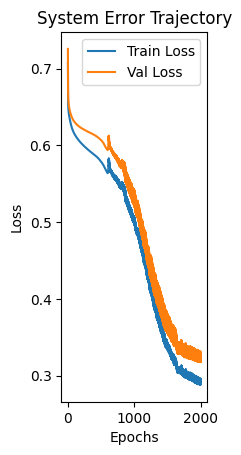

In [17]:
plt.subplot(1, 3, 1)
plt.plot(logs["t_loss"], label="Train Loss", color="tab:blue")
plt.plot(logs["v_loss"], label="Val Loss", color="tab:orange")
plt.title("System Error Trajectory")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

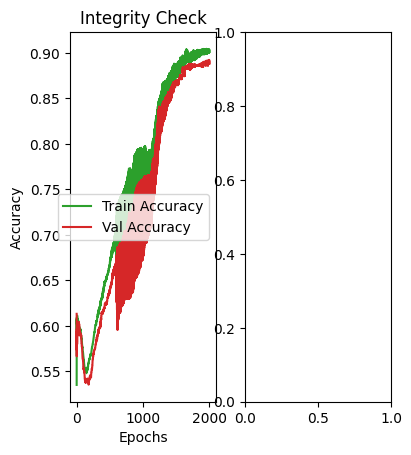

In [20]:
plt.subplot(1, 3, 2)
plt.plot(logs["t_acc"], label="Train Accuracy", color="tab:green")
plt.plot(logs["v_acc"], label="Val Accuracy", color="tab:red")
plt.title("Integrity Check")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 3, 3)
x_grid = np.linspace(-5, 5, 200)
y_grid = np.linspace(-5, 5, 200)
xx, yy = np.meshgrid(x_grid, y_grid)
grid_tensor = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)

with torch.no_grad():
    decision_surface = gdc_forward(grid_tensor).reshape(xx.shape)

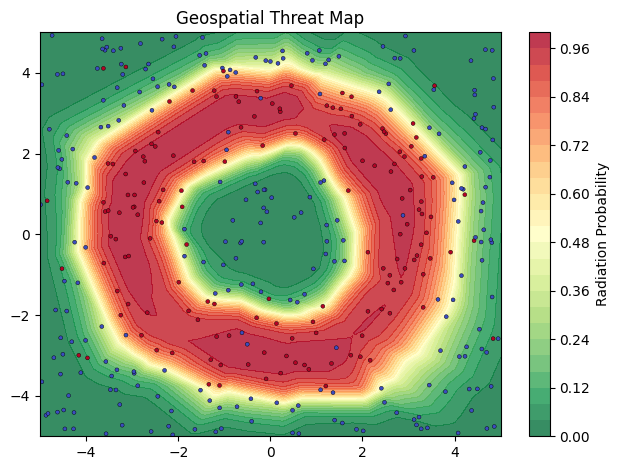

In [ ]:
plt.contourf(xx, yy, decision_surface, levels=25, cmap="RdYlGn_r", alpha=0.8)
plt.colorbar(label="Radiation Probability")
 
plt.scatter(X_val[:400, 0], X_val[:400, 1], c=Y_val[:400, 0], s=8, cmap="coolwarm", edgecolors='black', linewidth=0.3)
plt.title("Geospatial Threat Map")

plt.tight_layout()
plt.show()